In [59]:
%matplotlib inline

# Import packages and functions
import modelbase
import numpy as np
import pandas as pd
import os
import importlib
import sys
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm, CenteredNorm, SymLogNorm, Normalize
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import find_peaks
from scipy.stats import iqr
from scipy.integrate import simpson
from scipy.optimize import minimize

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from sympy import Matrix, lambdify, linsolve, symbols
from warnings import warn
from os import listdir
from os.path import join

# Helper functions
import functions as fnc
import calculate_parameters_restruct as prm
import submodules.lightdescription.light_with_pigments as lip
from module_update_FlvandCCM import CO2sol
from calculate_parameters_restruct import unit_conv

from functions_custom_steady_state_simulator import get_ssflux, get_ssfluxes, calculate_ss_Q_red, calculate_ss_outputs, get_parametervariant_outputs, simulate_to_steady_state_custom
from functions_fluorescence_simulation import make_lights, make_adjusted_lights, create_protocol_NPQ, create_protocol_NPQ_short, create_protocol_noNPQ

# Import model functions
from get_current_model import get_model
# from module_update_phycobilisomes import add_OCP

idx = pd.IndexSlice

In [60]:
# Set to True to recalculate the results of analyses that take a long time
# Set to False to use pre-calculated results
settings = {
    "general":{
        # Set to True to plot/ recalculate all figures (VERY TIME INTENSIVE!)
        # Set to False to plot/ recalculate no figure
        # Set to None to use figure specific settings (below)

        "plot_all": True, 
        "recalculate_all": True,

        # Use multiprocessing
        "multiprocessing": True,
        "max_workers": 15,
    },
    # Figure specific settigs (overwritten by above settings)
    # Recalculation time with Intel Core i7, 16 cores, 64 GB memory
    "MCA":                          {"recalculate": False, "plot": True}, # Recalculation time: 30 min
    "CO2_fluxes_spectral":          {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "open_PS2s":                    {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "state_transitions_PAM":        {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "state_transitions_analysis":   {"recalculate": False, "plot": True}, # Recalculation time: 150 min
    "CO2_fluxes_monochrom":         {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "CO2_fluxes_monochrom_adapted": {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "sink_production_monochrom":    {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "PAM_blue_light":               {"recalculate": False, "plot": True}, # Recalculation time: 2 min
    "PAM_all_lights":               {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "electron_pathways":            {"recalculate": False, "plot": True}, # Recalculation time: 7 min
    "O2_CO2_fluxes":                {"recalculate": False, "plot": True}, # Recalculation time: 1 min
}

# Set the paths to save figures and objects
figure_path = Path("figures")
results_path = Path("results")

plot_format = ["svg", "png"]

# Reduce or increase the number of simulated points in appropriate analyses (1=default amount)
fraction_simulated_points = 0.3

In [61]:
# Apply general settings
for k,v in settings.items():
    if k!= "general":
        if settings["general"]["recalculate_all"] is not None:
            v["recalculate"] = settings["general"]["recalculate_all"]
        if settings["general"]["plot_all"] is not None:
            v["plot"] = settings["general"]["plot_all"]
        settings[k] = v

In [62]:
light_factor = 0.5

m,y0 = get_model()
s = Simulator(m)
s.initialise(y0)

s.update_parameter("pfd", lip.light_spectra("solar", 0.1*light_factor))
s.simulate(300)
s.update_parameter("pfd", lip.light_gaussianLED(440,70*light_factor))
s.simulate(600)
s.update_parameter("pfd", lip.light_gaussianLED(633,50*light_factor))
s.simulate(800)
s.update_parameter("pfd", lip.light_gaussianLED(440,70*light_factor))
s.simulate(1000)
s.update_parameter("pfd", lip.light_gaussianLED(480,70*light_factor))
t,y = s.simulate(1200)
s.update_parameter("pfd", lip.light_gaussianLED(670, 200*light_factor))
t,y = s.simulate(1400)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to hill
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


(<Figure size 1050x1050 with 1 Axes>,
 <AxesSubplot: xlabel='time [s]', ylabel='reduced fraction of pool'>)

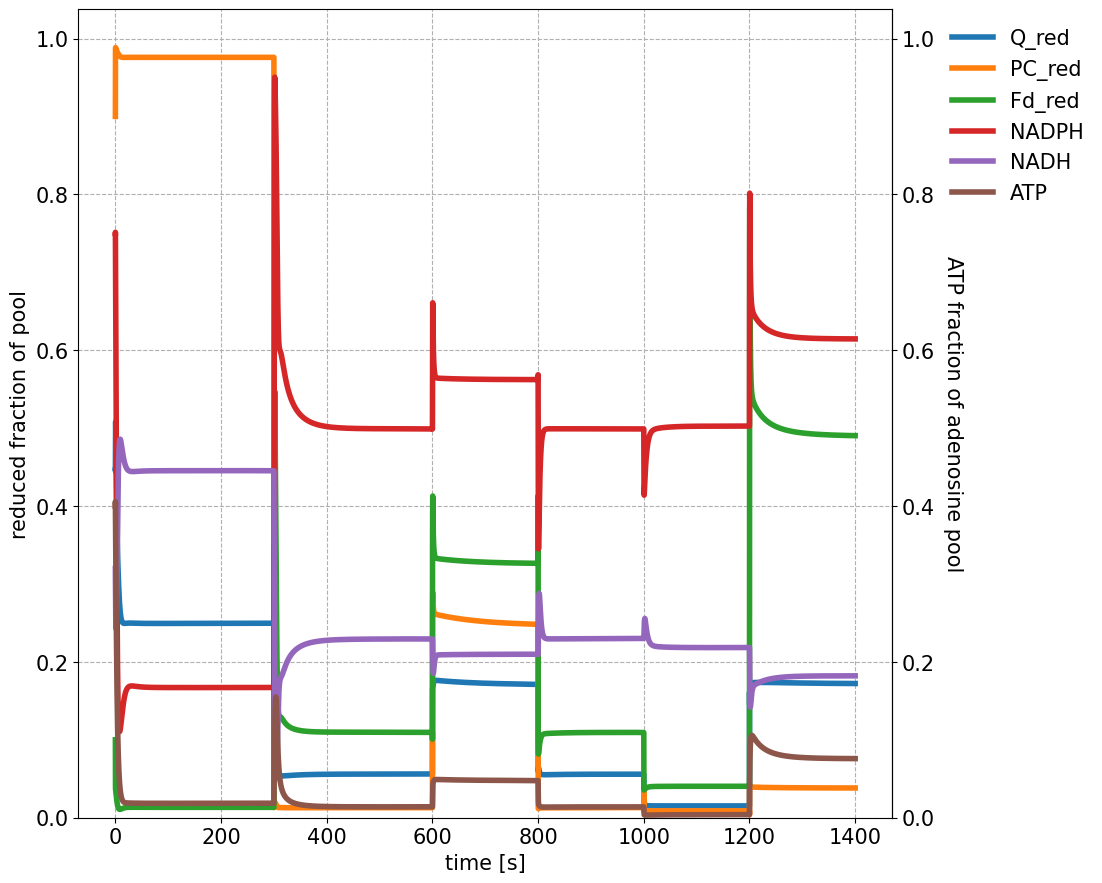

In [ ]:
fnc.plot_compound_ratios(s)


(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

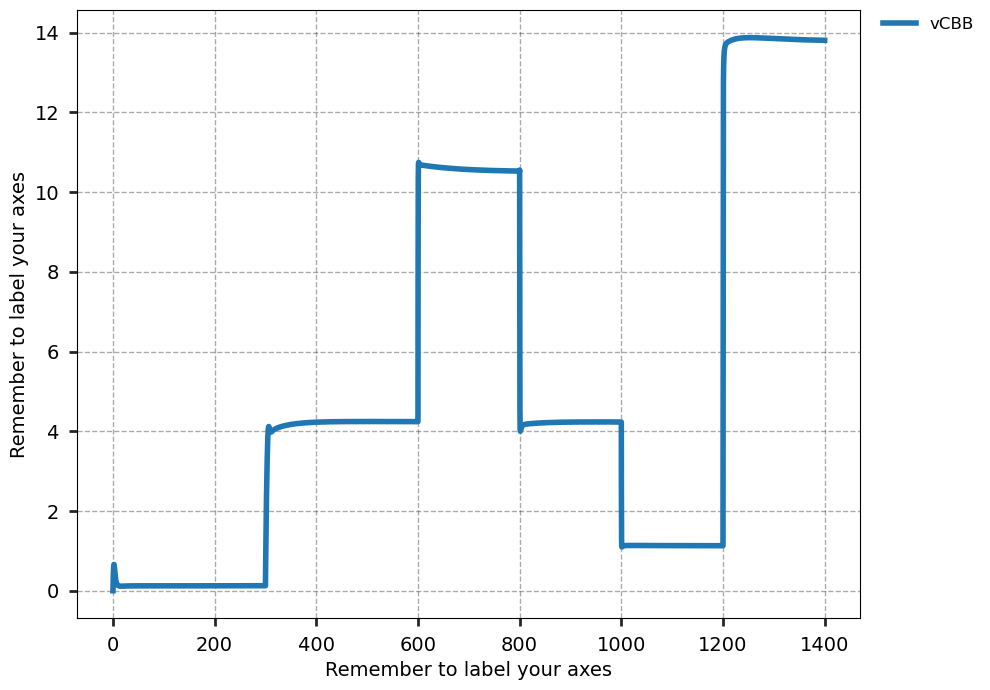

In [ ]:
s.plot_flux_selection("vCBB")

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

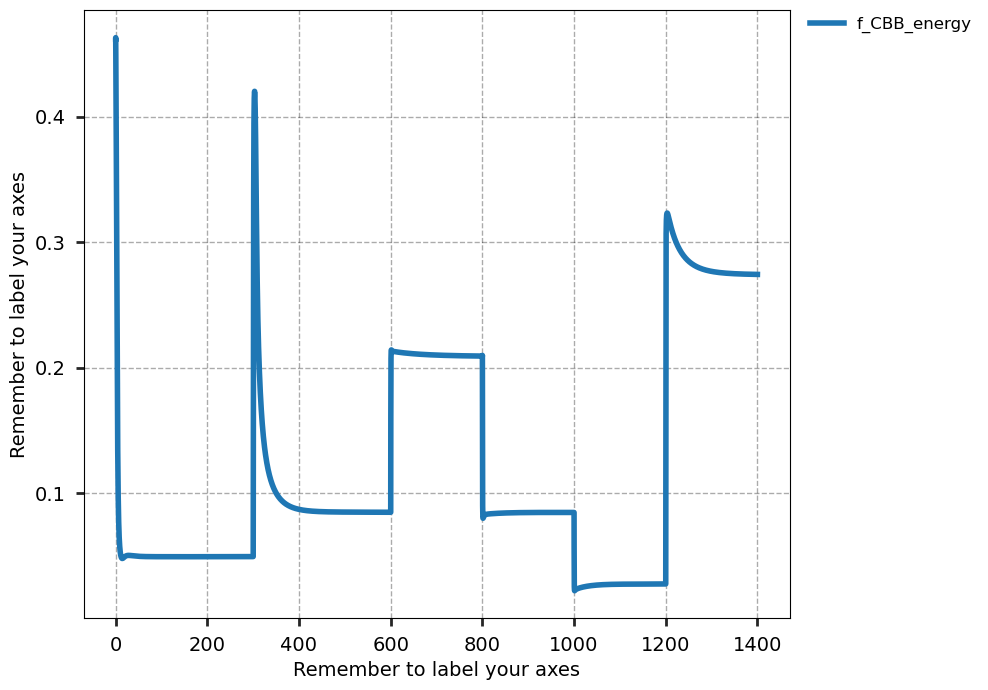

In [ ]:
s.plot_selection(["f_CBB_energy"])

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

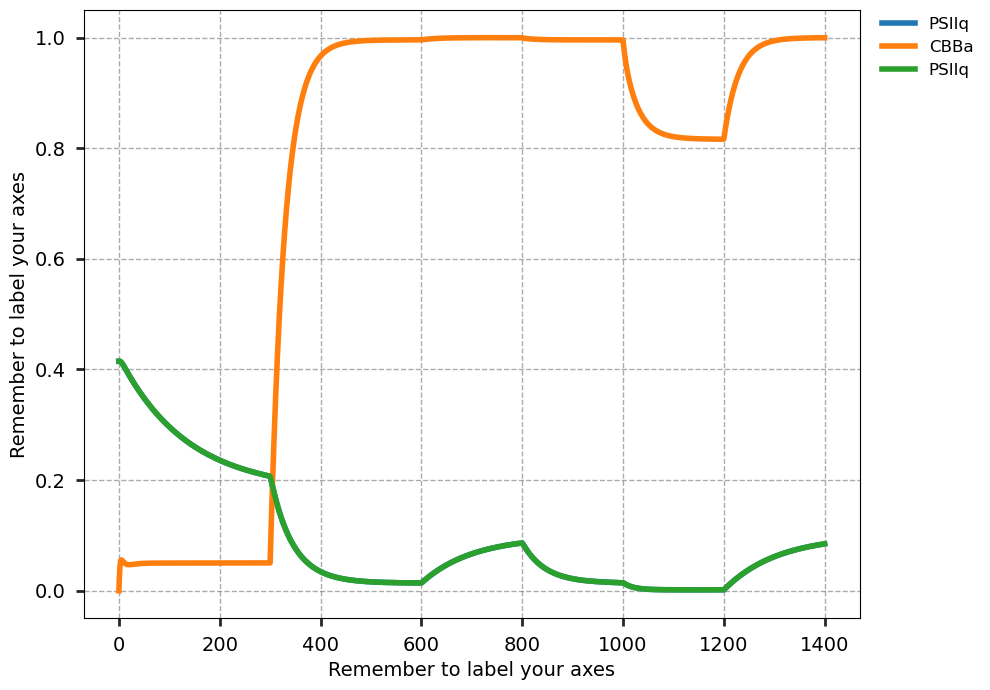

In [ ]:
s.plot_selection(["PSIIq", "CBBa", "PSIIq"])

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

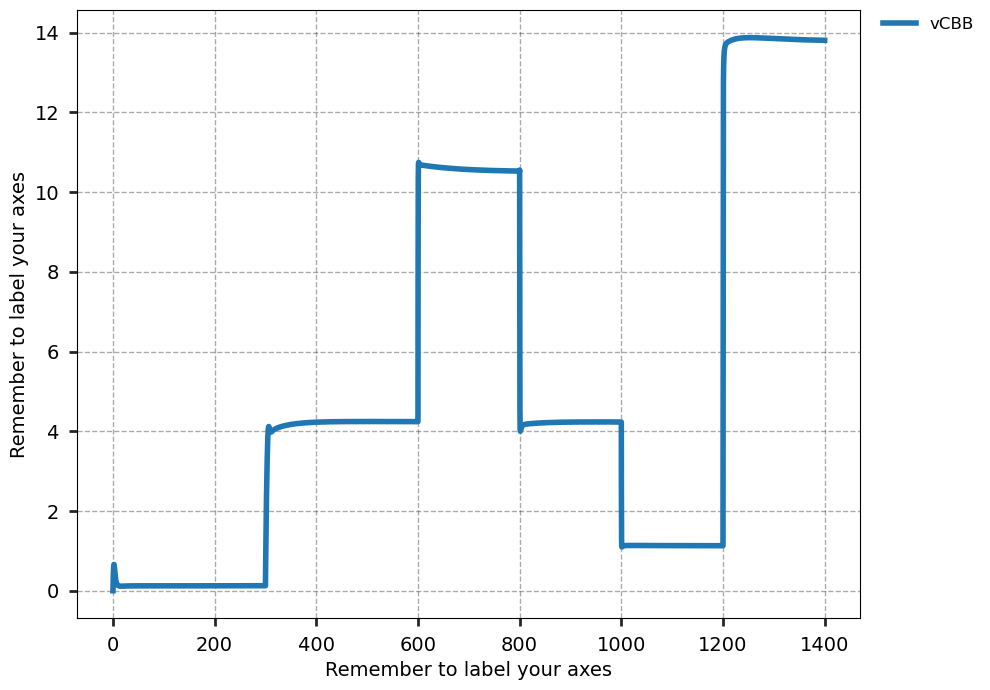

In [ ]:
s.plot_flux_selection("vCBB")

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

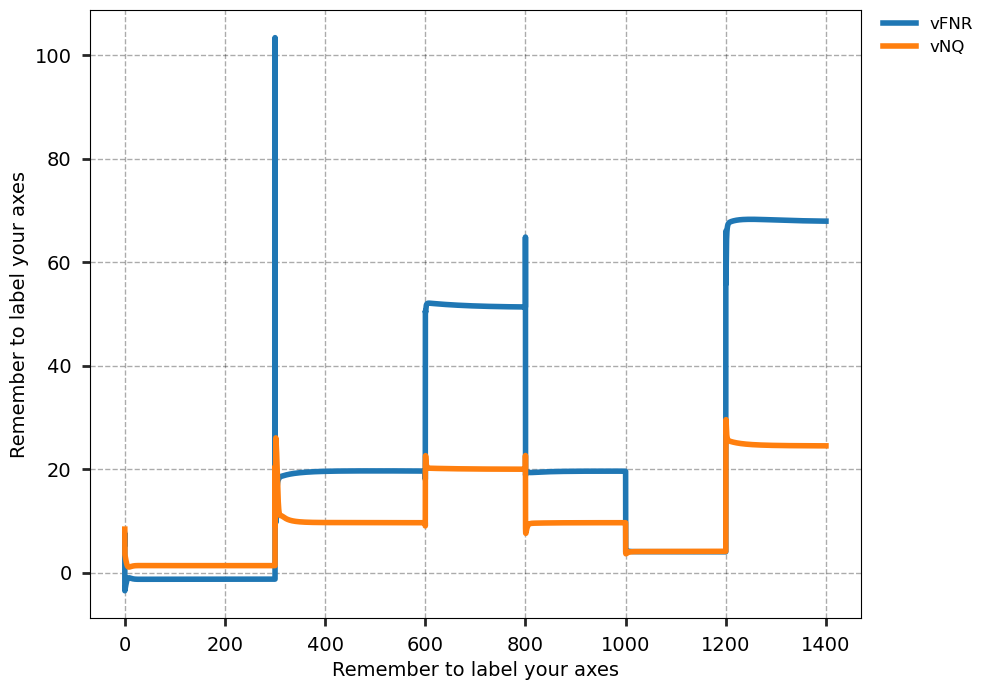

In [ ]:
s.plot_flux_selection(["vFNR", "vNQ"])

In [ ]:
m,y0 = get_model()
s = Simulator(m)
s.initialise(y0)

s.update_parameter("pfd", lip.light_spectra("solar", 0.1))
s.simulate(300)
s.update_parameter("pfd", lip.light_gaussianLED(440,70))
s.simulate(600)
s.update_parameter("pfd", lip.light_gaussianLED(670, 390))
t,y = s.simulate(1700)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to hill
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


(<Figure size 1050x1050 with 1 Axes>,
 <AxesSubplot: xlabel='time [s]', ylabel='reduced fraction of pool'>)

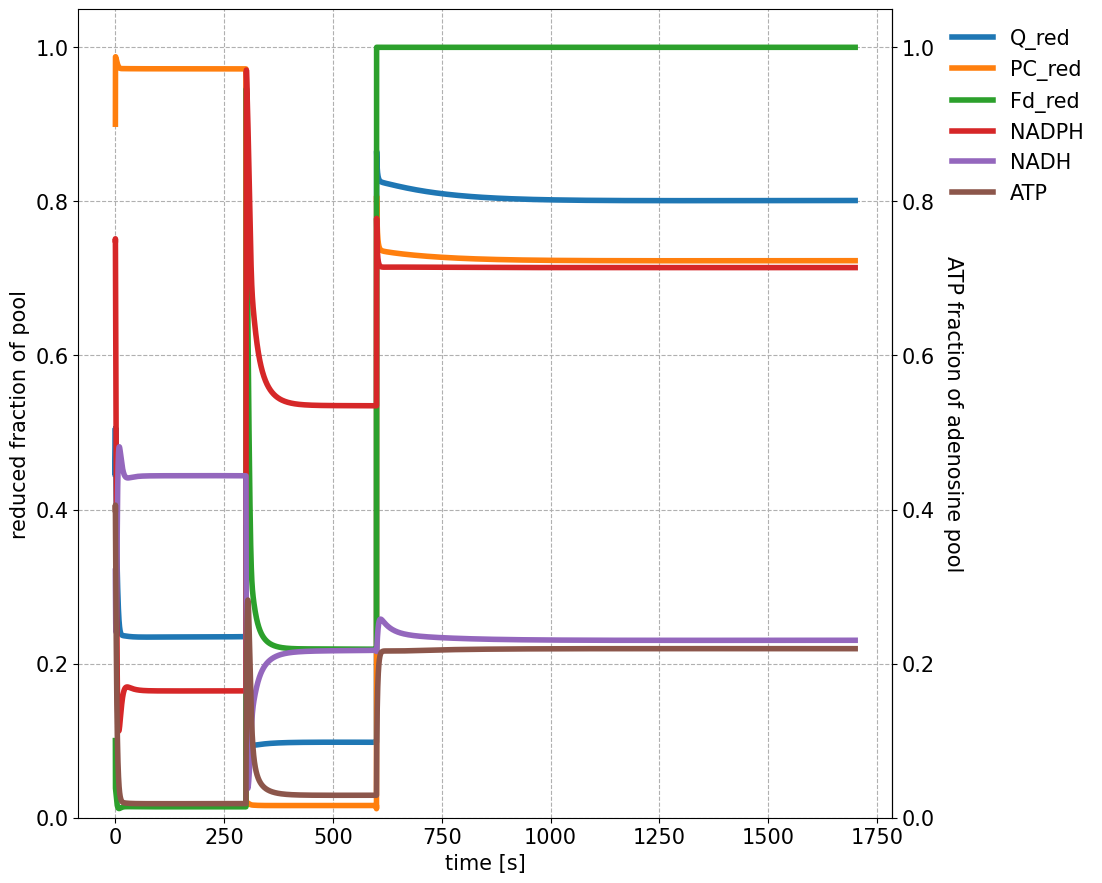

In [ ]:
fnc.plot_compound_ratios(s)

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

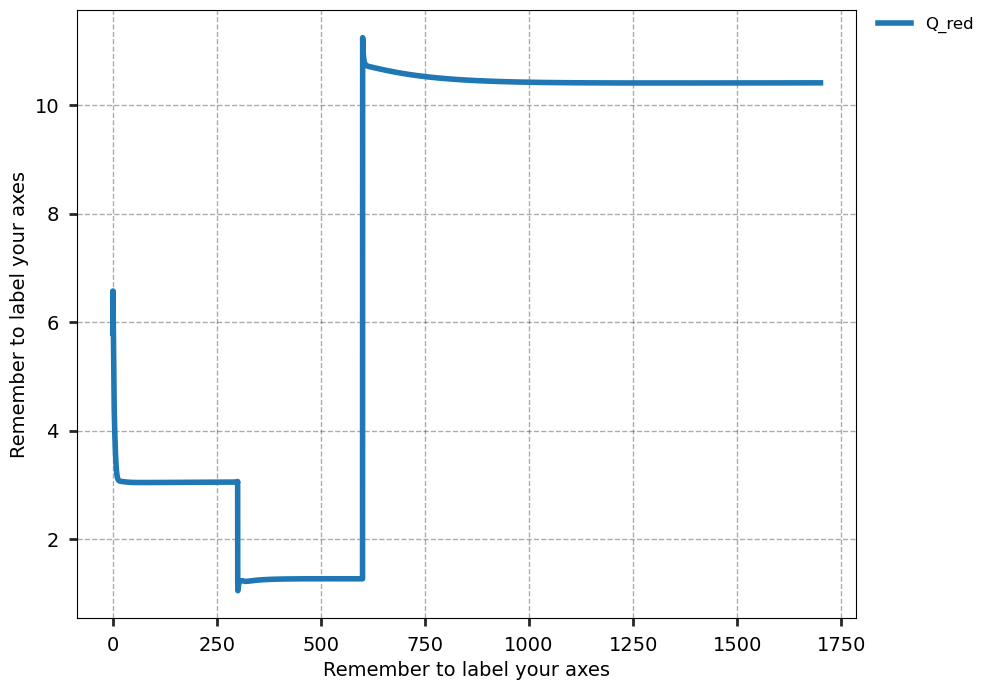

In [ ]:
s.plot_selection("Q_red")

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

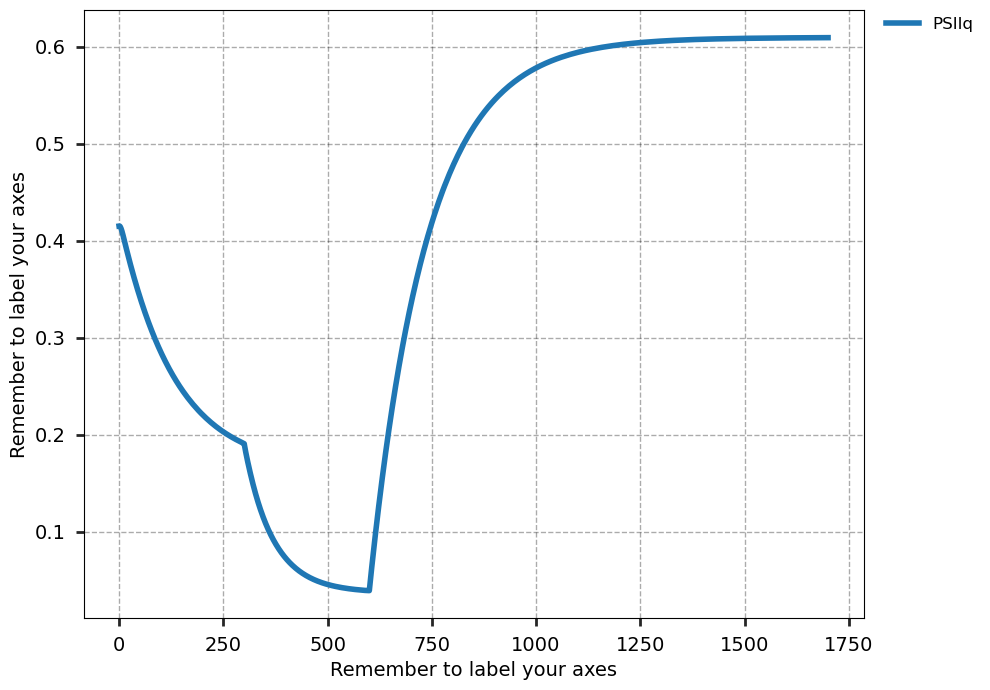

In [ ]:
s.plot_selection("PSIIq")

### Plan:

1. CO2 fixation curve with 11 different values of Flv Km
2. ST simulation with PBS decoupling from just PSII
3. Biotech analysis with adapted cells
4. PAM without fitting
5. Simulation with different CO2 treatment
   - Steady state CBB rate (& RMSE of relative time difference)
   1. 11 different CCM factors between 100 and 1000
   2. 11 different CO2 concentrations between 400 ppm and 50000 ppm

# Carbon Dioxide Fluxes under Different Light Sources with varying KM_ATP

In [ ]:
# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

varied_params = {
    "KMATP" : np.logspace(np.log10(0.3), np.log10(3), 11),
    # "k_Q" : np.logspace(np.log10(0.3), np.log10(3), 11)
}

for varied_param, param_factors in varied_params.items():
    lights = {"solar": "Solar Light"}
    intens = np.linspace(20, 300, 25)
    params_variations = {f"KMATP_{k:.2f}": k* m_MCA.get_parameter(varied_param) for k in param_factors}

    CO2s = pd.DataFrame(index=intens, columns = params_variations.keys())

    for nam, param_var in params_variations.items():
        m_MCA.update_parameter(varied_param, param_var)
        if settings["CO2_fluxes_spectral"]["recalculate"]:
            _CO2s = get_ssfluxes(
                m_MCA, 
                y0, 
                lip.light_spectra, 
                "vCBB", # "vCCM"
                list(lights.keys()), 
                intens,
                multiprocessing = settings["general"]["multiprocessing"],
                max_workers = settings["general"]["max_workers"],
            )

            CO2s[nam] = _CO2s

    if settings["CO2_fluxes_spectral"]["recalculate"]:
        fnc.save_obj_dated(CO2s, f"rev_ss_CO2s_{varied_param}vary", results_path)

The decline of CET together with the non-linear kinetic of the CBB lead to the fixation "bump"

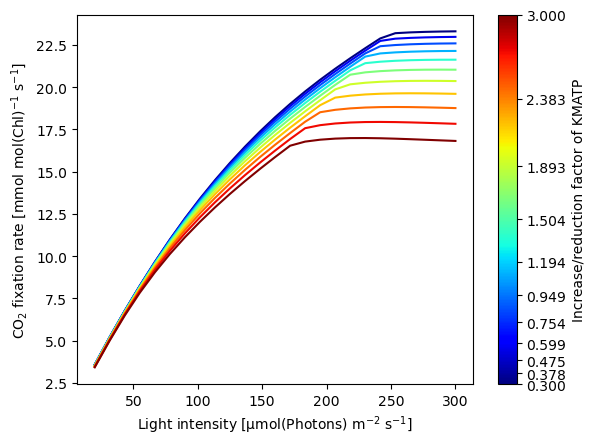

In [ ]:
if settings["CO2_fluxes_spectral"]["plot"]:
    for varied_param, param_factors in varied_params.items():
        CO2s = fnc.load_obj_dated(f"rev_ss_CO2s_{varied_param}vary", results_path)

        fig, ax = plt.subplots()

        log_factors = np.log10(param_factors)

        norm = mpl.colors.Normalize(vmin=log_factors.min(), vmax=log_factors.max())
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
        cmap.set_array([])

        norm2 = mpl.colors.Normalize(vmin=param_factors.min(), vmax=param_factors.max())
        cmap2 = mpl.cm.ScalarMappable(norm=norm2, cmap=mpl.cm.jet)
        cmap2.set_array([])

        for i, val in enumerate(CO2s.columns):
            ax.plot(CO2s.iloc[:,i], c=cmap.to_rgba(log_factors[i]))
        ax.set_ylabel("CO$_2$ fixation rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]")
        ax.set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")

        fig.colorbar(cmap2, ticks=param_factors, ax=ax, label=f"Increase/reduction factor of {varied_param}")

# Carbon Dioxide Fluxes under varying carbon concentration and uptake

In [ ]:
# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

# Define tested CO2 concentrations and CCM factors
CO2_concs = np.logspace(np.log10(0.0004), np.log10(0.05), 10)  # [mol l^-1 atm^-1] solubility of CO2 in 25 °C water with ~10 ‰ Cl^- ions (Li1971)
CCM_factors = np.logspace(2,3,10)

CO2s = pd.DataFrame(np.nan, index=CO2_concs, columns=CCM_factors)

for CO2_conc in CO2_concs:
    for CCM_factor in CCM_factors:
        if settings["CO2_fluxes_spectral"]["recalculate"]:
            m_MCA.update_parameters({
                "CO2ext_pp": CO2_conc,
                "fCin": CCM_factor
            })

            _CO2s = get_ssflux(
                m_MCA,
                y0,
                lip.light_spectra,
                "vCBB",
                ("solar", 250),
                tolerance=1e-4,
                rel_norm=False
            )

            CO2s.loc[CO2_conc, CCM_factor] = _CO2s

fnc.save_obj_dated(CO2s, "rev_ss_CO2s_CO2vary", results_path)

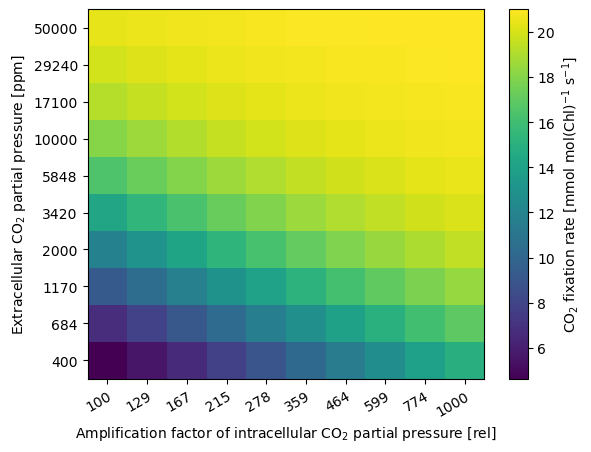

In [ ]:
if settings["CO2_fluxes_spectral"]["plot"]:
    CO2s = fnc.load_obj_dated("rev_ss_CO2s_CO2vary", results_path)
    fig, ax = fnc.plot_heatmap(CO2s, clab=f"CO$_2$ fixation rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]")
    ax.set_yticklabels(np.round(CO2s.index.to_numpy() * 1e6).astype(int))
    ax.set_xticklabels((f"{x:.0f}" for x in (CO2s.columns.to_numpy())), rotation=30, ha="right", rotation_mode='anchor')
    ax.set_xlabel("Amplification factor of intracellular CO$_2$ partial pressure [rel]")
    ax.set_ylabel("Extracellular CO$_2$ partial pressure [ppm]")

In [ ]:
m_MCA,y0 = get_model(check_consistency=False, verbose=False)

In [ ]:
# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

# Define tested CO2 concentrations and CCM factors
CO2_concs = np.logspace(np.log10(0.00004), np.log10(0.05), 10)  
CCM_factors = np.logspace(2,3,10)

O2s = pd.DataFrame(np.nan, index=CO2_concs, columns=CCM_factors)

for CO2_conc in CO2_concs:
    for CCM_factor in CCM_factors:
        if settings["CO2_fluxes_spectral"]["recalculate"]:
            m_MCA.update_parameters({
                "CO2ext_pp": CO2_conc,
                "fCin": CCM_factor
            })

            _O2s = get_ssflux(
                m_MCA,
                y0,
                lip.light_spectra,
                "vO2out",
                ("cool_white_led", 800),
                tolerance=1e-4,
                rel_norm=False
            )

            O2s.loc[CO2_conc, CCM_factor] = _O2s

fnc.save_obj_dated(O2s, "rev_ss_O2s_CO2vary", results_path)

In [ ]:
# Fit to the Benschop2003 CO2 fixation data
Benschop2003 = pd.read_csv(Path("data/CO2fixation_Benschop2003.csv"), index_col=0)

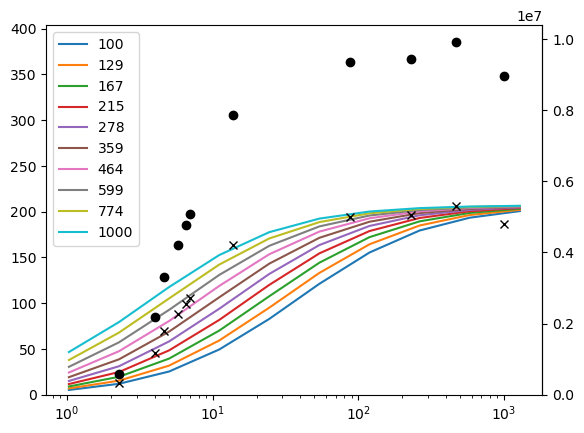

In [ ]:
# Calculate the theoretical dissolved CO2 medium concentrations at the external partial pressures
# Assuming T=30°C, S=35 (Salinity of seawater)
T= 303.150 # [K]
S = 35 # [unitless] Salinity
CO2_dis = CO2sol(T,S,CO2_concs) # [mol l^-1]
CO2_dis = CO2_dis * 1e6 # [µmol l^-1]

CO2_conv_fac = CO2sol(T,S,1) * 1e6

O2s_conv = O2s * unit_conv(['mmol mol(Chl)-1 -> mmol g(Chl)-1', 's-1 -> h-1'])

fig, ax = plt.subplots()
for i, CCM_factor in enumerate(CCM_factors):
    ax.plot(CO2_dis, O2s_conv.loc[:,CCM_factor].to_numpy(), label=f"{CCM_factor:.0f}")
    ax.set_xscale("log")


# Add values from Benschop2003
ax.plot(Benschop2003.index.to_numpy(), Benschop2003.to_numpy(), "ko")
ax.plot(Benschop2003.index.to_numpy(), Benschop2003.to_numpy() * (O2s_conv.max().max() / (Benschop2003.max().to_numpy())), "kx")
ax.set_ylim(0)
ax.secondary_yaxis(1, functions=(lambda x:x*CO2_conv_fac, lambda x:x/CO2_conv_fac))

ax.legend()

# Test State Transition Models (Figures 4b, 4c, & 12)

## State Transition Models PAM (Figure 4b)

In [ ]:
m, y0 = get_model()

In [ ]:
# Alter models with the tested state transition mechanisms
def remove_statetransitions_default(m, y0):
    m.remove_reactions(["vPSIIunquench", "vPSIIquench"])

    # Adapt y0
    y0["PSII"] = m.get_parameter("PSIItot")
    return m, y0


# PBS detachment model
def vPBS_detach(Q_ox, PBS_free, Q_red, kPBS_detach, kPBS_attach, PBS_freemax):
    return rf.reversible_mass_action_2_2((PBS_freemax-PBS_free), Q_ox, PBS_free, Q_red, kPBS_detach, kPBS_attach)

def update_statetransitions_detachpbs1(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Adapt y0
    y0["PBS_PS1"] = 0.45
    y0["PBS_PS2"] = 0.55

    # Add new parameters and functions
    m.add_parameters({
        "kPBS_detach":1e-3,
        "kPBS_attach":1e-3,
        "PBS_freemax":0.5
    })

    m.add_reaction_from_args(
        rate_name="vPBS_detach",
        function=vPBS_detach,
        stoichiometry={"PBS_PS1": -1, "PBS_PS2":-1},
        args=["Q_ox", "PBS_free", "Q_red", "kPBS_detach", "kPBS_attach", "PBS_freemax"],
    )

    return m, y0

def update_statetransitions_detachpbs_PSIIonly(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Adapt y0
    y0["PBS_PS1"] = 0.45
    y0["PBS_PS2"] = 0.55

    # Add new parameters and functions
    m.add_parameters({
        "kPBS_detach":1e-3,
        "kPBS_attach":1e-3,
        "PBS_freemax":0.5
    })

    m.add_reaction_from_args(
        rate_name="vPBS_detach",
        function=vPBS_detach,
        stoichiometry={"PBS_PS2":-1},
        args=["Q_ox", "PBS_free", "Q_red", "kPBS_detach", "kPBS_attach", "PBS_freemax"],
    )

    return m, y0

# PBS mobile model
def vPBS_mobile(Q_ox, PBS_PS1, Q_red, PBS_PS2, kPBS_toPS1, kPBS_toPS2, PBS_PS1min, PBS_PS2min):
    return rf.reversible_mass_action_2_2(
        (PBS_PS2 - PBS_PS2min), Q_red, 
        (PBS_PS1 - PBS_PS1min), Q_ox, 
        kPBS_toPS1, kPBS_toPS2
    )

def update_statetransitions_mobilepbs(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Adapt y0
    y0["PBS_PS1"] = 0.45
    y0["PBS_PS2"] = 0.55

    # Add new parameters and functions
    m.add_parameters({
        "kPBS_toPS1":1e-3,
        "kPBS_toPS2":1e-3,
        "PBS_PS1min": 0.35, 
        "PBS_PS2min": 0.45,
    })

    m.add_reaction_from_args(
        rate_name="vPBS_mobile",
        function=vPBS_mobile,
        stoichiometry={"PBS_PS1": 1, "PBS_PS2":-1},
        args=["Q_ox", "PBS_PS1", "Q_red", "PBS_PS2", "kPBS_toPS1", "kPBS_toPS2", "PBS_PS1min", "PBS_PS2min"],
    )

    return m, y0

# Spillover model
def vspillover(spill, Q_red, Q_ox, kspill, kunspill, spillmax):
    return rf.reversible_mass_action_2_2(spillmax-spill, Q_red, spill, Q_ox, kspill, kunspill)

def ps_normabsorption_spill(time, PBS_PS1, PBS_PS2, spill, complex_abs, PSItot, PSIItot):
    light_ps1 = (complex_abs["ps1"] + complex_abs["pbs"] * PBS_PS1) / PSItot
    light_ps2 = (complex_abs["ps2"] + complex_abs["pbs"] * PBS_PS2) / PSIItot

    if isinstance(light_ps2, float) and isinstance(time, np.ndarray):
        light_ps1 = np.repeat(light_ps1, len(time))
        light_ps2 = np.repeat(light_ps2, len(time))

    return (light_ps1 + spill * light_ps2), ((1-spill) * light_ps2)

def update_statetransitions_spillover(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Add new parameters and functions
    m.add_compound("spill")
    y0["spill"] = 0

    m.add_parameters({
        "kspill": 1e-5,
        "kunspill" :1e-5,
        "spillmax": 0.1  
    })

    m.add_reaction_from_args(
        rate_name="vspillover",
        function=vspillover,
        stoichiometry={"spill": 1},
        args=["spill", "Q_red", "Q_ox", "kspill", "kunspill", "spillmax"],
    )

    m.update_algebraic_module(
        module_name="ps_normabsorption",
        function=ps_normabsorption_spill,
        args=["time", "PBS_PS1", "PBS_PS2", "spill", "complex_abs", "PSItot", "PSIItot"],
        check_consistency=False,
    )

    m.update_algebraic_module(  # >> changed: added <<
        module_name="ps_normabsorption_ML",
        function=ps_normabsorption_spill,
        args=[
            "time",
            "PBS_PS1",
            "PBS_PS2",
            "spill",
            "complex_abs_ML",
            "PSItot",
            "PSIItot",
        ],
        check_consistency=False,
    )

    return m, y0

In [ ]:
# Recalculate a run simulation with altered parameters
# Intended only for recalculating fluorescence under different measuring light
def recalculate_with_altered_parameters(sim, parameters, recalc_fluxes=False, recalc_full_results=False):
    s = sim.copy()
    s.full_results = None

    for i in range(len(s.simulation_parameters)):
        new_param = s.simulation_parameters[i].copy()
        new_param.update(parameters)
        s.simulation_parameters[i] = new_param
    
    if recalc_fluxes:
        s.fluxes = None
        s._calculate_fluxes()
    
    if recalc_full_results:
        s.full_results = None
        s._calculate_full_results()

    return s

# Calculate the relative difference in fluorescence with altered measuring light
def relative_fluo_diff(sims, sims_blueML):
    res = {}
    for nam in sims:
        # Get the relative fluorescences and calculate the RMSE
        fluo = sims[nam].get_full_results_df()["Fluo"]
        fluo_blueML = sims_blueML[nam].get_full_results_df()["Fluo"]

        fluo_diff = (fluo/fluo.max()) - (fluo_blueML/fluo_blueML.max())
        rmse = np.sqrt(np.mean(fluo_diff**2))
        res[nam] = rmse
    return res

# Simulate a PAM experiment for the state transitions models
def dummy(m,y0):
    return m, y0

def simulate_statetransition_models(models, loadsim = False, savesim=False):
    sims = {}
    for nam, model in models.items():
        if not loadsim:
            m,y0 = get_model(check_consistency=False, verbose=False, pbs_behaviour=model["pbs_behaviour"])
            m,y0 = model["fun"](m, y0)

            m.update_parameters(model["param"])
            y0 = fnc.get_steadystate_y0(m, y0)

            # Initialise the model
            s=Simulator(m)
            s.initialise(y0)

            # Simulate the appropriate protocol
            protocol = create_protocol_NPQ_short(*make_lights())

            s = fnc.simulate_protocol(s, protocol)
            if savesim:
                fnc.save_Simulator_dated(s, f"rev_pamsim_{nam}", results_path)
        else:
            s = fnc.load_Simulator_dated(f"rev_pamsim_{nam}", results_path)

        sims[nam] = s
    return sims


In [ ]:
# Plotting functions
def add_phasebox(ax, t_start, t_end, text, height, ylow=1, adj_plotheight=False):
    box = Rectangle(
        [t_start, ylow],
        t_end-t_start,
        height,
        fill=False,
        ec="k",
    )
    ax.add_patch(box)
    ax.text(
        t_start + 0.5*(t_end-t_start),
        ylow+0.5*height,
        text,
        ha="center",
        va="center"
    )
    if adj_plotheight:
        ax.set_ylim(ymax=ax.get_ylim()[1]+height)
    return ax

def add_insetbox(ax, xmin, xmax, ymin, ymax, adj_plotheight=None):
    height = ymax-ymin
    box = Rectangle(
        [xmin, ymin],
        xmax-xmin,
        height,
        fill = False,
        fc="w",
        ec="k",
        transform = ax.transAxes
    )
    ax.add_patch(box)
    if adj_plotheight is not None:
        adj_y = np.array(ax.get_ylim()) + np.array(adj_plotheight)
        ax.set_ylim(adj_y)
    return ax

def annotate_phases_statetrans(ax):
    cycles = np.array([3,3,15,15])
    times = np.cumsum(cycles * 20)
    ax = add_phasebox(ax, 0, times[0], "D", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, times[0], times[1], "S1", 0.05, 1.02)
    ax = add_phasebox(ax, times[1], times[2], "S2", 0.05, 1.02)
    ax = add_phasebox(ax, times[2], times[3], "S1", 0.05, 1.02)

    return ax

In [ ]:
# Define the state transition models with the necessary parameters
models = {
    "mnost":{
        "pbs_behaviour": "static",
        "fun": remove_statetransitions_default,
        "param":{},
        "param_bounds":{}
    },
    "m0":{
        "pbs_behaviour": "static",
        "fun": dummy,
        "param":{
            "kUnquench": 0.1,
            "kQuench": 5e-4,
            "KMUnquench": 0.2,
        },
        "param_bounds":{
            "kUnquench": (0.01, 1),
            "kQuench": (5e-5, 5e-3),
            "KMUnquench": (0.01,0.3) ,
        }
    },
    "mspill":{
        "pbs_behaviour": "static",
        "fun": update_statetransitions_spillover,
        "param":{
            "kspill": 5e-4,
            "kunspill" :5e-4,
            "spillmax": 0.3 
        },
        "param_bounds":{
            "kspill": (5e-5, 5e-3),
            "kunspill": (5e-5, 5e-3),
            "spillmax": (0.1,0.6) ,
        }
    },
    "mpbsd":{
        "pbs_behaviour": "dynamic",
        "fun": update_statetransitions_detachpbs1,
        "param":{
            "kPBS_detach":1e-4,
            "kPBS_attach":1e-3,
            "PBS_freemax":0.1
        },
        "param_bounds":{
            "kPBS_detach": (1e-5, 1e-3),
            "kPBS_attach": (1e-4, 1e-2),
            "PBS_freemax": (0.01,0.3),
        }
    },
    "mpbsd2":{
        "pbs_behaviour": "dynamic",
        "fun": update_statetransitions_detachpbs_PSIIonly,
        "param":{
            "kPBS_detach":1e-4,
            "kPBS_attach":1e-3,
            "PBS_freemax":0.1
        },
        "param_bounds":{
            "kPBS_detach": (1e-5, 1e-3),
            "kPBS_attach": (1e-4, 1e-2),
            "PBS_freemax": (0.01,0.3),
        }
    },
    "mpbsm":{
        "pbs_behaviour": "dynamic",
        "fun": update_statetransitions_mobilepbs,
        "param":{
            "kPBS_toPS1":1e-3,
            "kPBS_toPS2":1e-3,
            "PBS_PS1min": 0.25, 
            "PBS_PS2min": 0.35,
        },
        "param_bounds":{
            "kPBS_toPS1": (1e-4, 1e-2),
            "kPBS_toPS2": (1e-4, 1e-2),
            "PBS_PS1min": (0, 0.5),
            "PBS_PS2min": (0, 0.5)
        }
    }
}

# Simulate the models
sims = simulate_statetransition_models(
    models, 
    loadsim=not settings["state_transitions_PAM"]["recalculate"], 
    savesim=settings["state_transitions_PAM"]["recalculate"]
)

if settings["state_transitions_PAM"]["plot"]:
    titles = {
        "m0": "PSII-quenching Model",
        "mspill": "Spillover Model",
        "mpbsm": "PBS-Mobile Model",
        "mpbsd": "PBS-detachment Model (both PS)",
        "mpbsd2": "PBS-detachment Model (only PSII)",
    }

    # Plot of PAM traces
    fig, axes = plt.subplots(3,2, figsize=(15,7), sharey=False, sharex = True)

    axdims = pd.DataFrame(index=range(4), columns=["ymin","ymax"])

    for i, (ax, nam) in enumerate(zip(axes.flatten(), titles)):
        s = sims[nam]
        if nam == "mnost":
            continue

        # Fluorescence plot
        fluo = s.get_full_results_df()["Fluo"]
        ax.plot(fluo / fluo.max())
        axdims.iloc[i] = ax.get_ylim()
        ax.set_title(titles[nam])

        ax = annotate_phases_statetrans(ax)
        yadj = 0.08
        ax.set_ylim(ymin=0)
        # ax = add_insetbox(ax, 0.69, 0.975, 0.01 + yadj, 0.2 + yadj, adj_plotheight=[-0.15, 0])
        ax = fnc.add_lightbar(s, ax, 1000, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, spectrum_maskalpha=0, pad_top=0.08, annotation_twoline=False, annotation_light_c="w", annotation_size = 6)
    fig. tight_layout()

    fnc.savefig_dated(fig, "rev_stmodels_pam", type=plot_format, path=figure_path)

## State Transition Models Analysis (Figure 4c & 12)

In [ ]:

# Calculate steady state Q_reds under a range of parameter values
if settings["state_transitions_analysis"]["recalculate"]:
    print("Calculating Qreds and Fms...")
    Q_reds, Fms = get_parametervariant_outputs( # Took 12h with 10 sample points
        models, 
        sims, 
        n=10, 
        multiprocessing=settings["general"]["multiprocessing"],
        max_workers=settings["general"]["max_workers"],
    ) 
    # Recalculate the fluorescence trace with blue measuring light
    sims_blueML = {k:recalculate_with_altered_parameters(s, {"pfd_ML": lip.light_gaussianLED(450,1,1e-3)}, recalc_full_results=True) for k,s in sims.items()}

    fnc.save_obj_dated(Q_reds, "rev_stmodels_Qreds", results_path)
    fnc.save_obj_dated(Fms, "rev_stmodels_Fms", results_path)
    fnc.save_Simulator_dated(sims_blueML, "rev_stmodels_blueML", results_path)
elif settings["state_transitions_analysis"]["plot"]:
    print("Loading Qreds and Fms...")
    Q_reds = fnc.load_obj_dated("rev_stmodels_Qreds", results_path)
    Fms = fnc.load_obj_dated("rev_stmodels_Fms", results_path)
    sims_blueML = fnc.load_Simulator_dated("rev_stmodels_blueML", results_path)

if settings["state_transitions_analysis"]["plot"]:
    # Calculate the relative alleviation in PQ reduction
    Q_reds_rel = {k:(Q_reds["mnost"]-v[np.invert(np.isnan(v))])/Q_reds["mnost"] for k,v in Q_reds.items() if k != "mnost"}

    # Calculate the RMSE of fluorescence under dfferent measuring lights
    bluefluo_rmse = relative_fluo_diff(sims, sims_blueML)

In [ ]:
if settings["state_transitions_analysis"]["plot"]:
    # Plot of PQ reduction alleviation
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    ax=axes[0]
    ax.axhline(0, linestyle="--", c="grey")
    bp = ax.boxplot([Q_reds_rel[x] for x in titles], patch_artist=True,
                    showmeans=False, showfliers=False, widths=0.1)
    bp_colors = np.repeat("white", 4)
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    bp = ax.violinplot([Q_reds_rel[x] for x in titles], showextrema=False)
    for pc in bp['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.set_title("Alleviation of PQ reduction")
    ax.set_xticks(range(1,6), titles.values(),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative decrease in PQ reduction [rel.]")


    # Plot of reduction in fluorescence level
    ax=axes[1]
    data = [Fms[x][np.invert(np.isnan(Fms[x]))] for x in titles]
    ax.axhline(0, linestyle="--", c="grey")
    bp = ax.boxplot(data, patch_artist=True,
                    showmeans=False, showfliers=False, widths=0.1)
    bp_colors = np.repeat("white", 5)
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    bp = ax.violinplot(data, showextrema=False)
    for pc in bp['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.set_title("Fm decrease during state 2")
    ax.set_xticks(range(1,6), titles.values(),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative Fm reduction from state 1 to state 2 [rel.]")

    fig.tight_layout()
    fig. subplots_adjust(wspace=0.25)
    fnc.savefig_dated(fig, "rev_stmodels_analysis", type=plot_format, path=figure_path)

    # Plot of RMSE from Fluorescence calculation with blue ML
    fig, ax = plt.subplots()
    ax.bar(range(5) ,[bluefluo_rmse[x] for x in titles], fill=False) 

    ax.set_title("")
    ax.set_xticks(range(5),list(titles.values()),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative fluorescence RMSE after ML change [AU]")
    ax.set_title("Fluorescence difference with blue measuring light")
    fnc.savefig_dated(fig, "rev_stmodels_FblueRMSE", type=plot_format, path=figure_path, bbox_inches="tight")

# Productivity of different sinks with varying light (Figure 5b, 5c, & 13)

In [ ]:
m,y0 = get_model()

## Variable Sink Production under Monochromatic Lights (Figure 5b & 5c)

In [ ]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,light] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def normalise_concentrations(dat_conc):
    # Convert to [mg mg(Chla)^-1]
    dat_conc = dat_conc.div(dat_conc.loc['chla',:]) # convert to [mg mg(Chla)^-1]
    return dat_conc

def _get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo, fraction_is_monomers=True, output_is_monomers=False):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,growthlight]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,growthlight]), fraction_is_monomers=fraction_is_monomers, output_is_monomers=output_is_monomers)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    
    return res

def get_strain_parameters(dat, pbs_relfluo, ps_fraction_is_monomers=True, ps_output_is_monomers=False):
    # Get the pigments
    df_pigments = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
    df_pigments.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']
    df_pigments = normalise_concentrations(df_pigments)

    # Get Phycobilisome attachment
    df_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
    df_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]
    
    # Get PS1:PS2 ratio
    df_PS1_PS2 = dat.loc[["PSI / PSII"],:]

    res = {}
    for wl in dat.columns:
        res[wl] = _get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, wl, pbs_relfluo)
    return res

In [ ]:
# Get the parameters defining different strains 
# (pigments, photosystems ratios, PBS attachment)
strains= pd.read_csv("data/Strainparameters_Zavrel2021.csv", header=0,skiprows=1, index_col=0).loc[:,"435":"687"]
strains.columns = strains.columns.astype(int)

strain_params = get_strain_parameters(
    strains, 
    {"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    ps_fraction_is_monomers=True,
    ps_output_is_monomers=False
)

In [ ]:
# Add a sink reaction with Mass Action kinetics to the model
def vsink(*X):
    return np.prod([float(x) for x in X])

def vcap(S, k, thresh):
    v = np.array(k * (S - thresh))
    v = v.reshape(-1)
    v[v<0] = 0
    return v

def add_sink(m, stoich, k=10):
    # Make a copy of the model, in case the mca adaption version should not be applied to the original model
    m = m.copy()

    # Add the sink parameters
    m.add_parameters({
        "kSink": k,
        "kCap_3PGA": 10,
        "threshCap_3PGA": 1000,
    })

    # Add the sink reaction
    modelstoich = {k:v for k,v in stoich.items() if k in m.get_compounds()}
    vargs = [k for k,v in stoich.items() if v<0]

    if len(modelstoich) != len(vargs):
        raise ValueError("stoichiometry unbalanced")

    m.add_reaction_from_args(
        rate_name=f"vsink",
        function=vsink,
        stoichiometry=modelstoich,
        args=["kSink"] + vargs
    )

    # Cap 3PGA levels
    m.add_reaction_from_args(
        rate_name=f"vCap_3PGA",
        function=vcap,
        stoichiometry={"3PGA":-1},
        args=["3PGA", "kCap_3PGA", "threshCap_3PGA"]
    )
    return m

# Get the steady-state sink production
def get_sink_mca_model(stoich):
    m_MCA,y0 = get_model(verbose=False, check_consistency=False)
    m_MCA = add_sink(m_MCA, stoich, k=10)
    s_MCA = Simulator(m_MCA)
    s_MCA.initialise(y0)
    return s_MCA

def get_sink_production(stoich, light_param, strain_params=None):
    # Create model
    s_MCA = get_sink_mca_model(stoich)

    # Adjust the light
    light = lip.light_gaussianLED(*light_param, spread=1e-3)
    s_MCA.update_parameter("pfd", light)

    if strain_params is not None:
        s_MCA.update_parameters(strain_params[light_param[0]])

    t,y = s_MCA.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
    if t is None:
        return np.nan
    else:
        return s_MCA.get_fluxes_dict()["vsink"][-1]

In [ ]:
# Different possible sink reactions with stoichiometries
sinks = {
    "ATP":{
        "stoich": {"ATP":-1},
        "title": "ATP"
    },
    "NADPH":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
        },
        "title": "NADPH"
    },
    "terpenes":{ # Stoichiometry according to Mills2020
        "stoich": {
            "ATP": -3,
            "NADPH": -1,
            "Ho": -5/m.get_parameter("bHo"),
            "Fd_ox": 4,
            "Fd_red":-4,
            "3PGA": -2,
        },
        "title": "Isoprene"
    },
    "sucrose":{
        "stoich": {
            "NADPH": -2,
            "Ho": -2/m.get_parameter("bHo"),
            "ATP": -3,
            "3PGA": -2
        },
        "title": "Sucrose"
    },
    "glycogen":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            "ATP": -2,
            "3PGA": -1
        },
        "title": "Glycogen"
    },
    "highATP":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            "ATP": -3,
            "3PGA": -1
        },
        "title": "Glycogen + 1 ATP"
    },
}

if settings["sink_production_monochrom"]["recalculate"]:
    # Calculate and plot the sink production
    for sink in sinks:
        wavelength = list(strain_params.keys())
        intensities = np.arange(20, 210, 10)

        light_params = np.meshgrid(wavelength, intensities)
        _light_params = zip(*[x.flatten() for x in light_params])

        _get_sink_production = partial(get_sink_production, sinks[sink]["stoich"])

        if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
            prods = np.array(list(map(_get_sink_production, _light_params)), dtype=float)
        else:
            with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
                prods = np.array(list(pe.map(_get_sink_production, _light_params)), dtype=float)
        prods = prods.reshape(-1,len(wavelength))
        prods = pd.DataFrame(
            prods, 
            index=pd.Index(intensities, name="Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]"),
            columns=pd.Index(wavelength, name="Wavelength [nm]")
        )
        fnc.save_obj_dated(prods, f"rev_sink_{sink}_wi", results_path)



In [ ]:
if settings["sink_production_monochrom"]["plot"]:
    for sink in sinks:
        prods = fnc.load_obj_dated(f"rev_sink_{sink}_wi", results_path)

        fig, ax = fnc.plot_heatmap(prods, clab=f"{sinks[sink]['title']} production rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]")
        ax.set_title(f"{sinks[sink]['title']} production under near-monochromatic lights")
        ax = fnc.add_na_annotation(ax, prods, 6)
        fig.tight_layout()
        fnc.savefig_dated(fig, f"rev_{sink}prod_singlemonochr", type=plot_format, path=figure_path)

In [ ]:
rodrigues2023 = pd.read_csv("data/rodrigues2023_isopreneproduction.csv", index_col=0)

colors = ["blue", "green", "red"]

measured_intensities = [50, 100]

for meas_int in measured_intensities:
    fig, ax = plt.subplots()

    prods = fnc.load_obj_dated(f"rev_sink_terpenes_wi", results_path)
    ax.plot(prods.loc[meas_int,:], color=colors[0])
    ax.set_title(f"Isoprene production at {meas_int} µmol(photons) m$^{{-2}}$ s$^{{-1}}$")
    ax.set_xlabel("Wavelength [nm]")
    ax.set_ylabel("Simulated isoprene production rate [mmol mol(Chl)$^{-1}$ s$^{-1}$]")
    ax.set_ylim(0)

    ax2 = ax.twinx()
    ax2.plot(rodrigues2023.loc[rodrigues2023["intensity_µmol_m2_s"] == meas_int, "isoprene_production_rate_umol_gDW_h"], marker="*", ls=None, color = colors[1], markerfacecolor=colors[1], markeredgecolor=colors[1], markersize=8)
    ax2.set_ylabel("Measured Isoprene production rate [µmol gDW$^{-1}$ h$^{-1}$]")
    ax2.set_ylim(0)
    ax2.spines.right.set_linewidth(3)
    ax2.spines.right.set_color(colors[1])
    ax2.spines.left.set_linewidth(3)
    ax2.spines.left.set_color(colors[0])

    ax3 = ax.twinx()
    ax3.plot(rodrigues2023.loc[rodrigues2023["intensity_µmol_m2_s"] == meas_int, "growth_rate_approx_h"], marker="^", ls=None, color = colors[2], markerfacecolor=colors[2], markeredgecolor=colors[2], markersize=8)
    ax3.set_ylabel("Measured growth rate [h$^{-1}$]")
    ax3.spines.right.set_position(("axes", 1.2))
    ax3.set_ylim(0)
    ax3.spines.right.set_linewidth(3)
    ax3.spines.right.set_color(colors[2])
    fig.tight_layout()
    fnc.savefig_dated(fig, f"rev_{sink}prod_singlemonochr", type=plot_format, path=figure_path)

# Pulse Amplitude Modulation (PAM) simulation (Figures 2a & 2b)

## PAM under of 435 nm adapted strain (Figure 2a)

In [ ]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

### Get the PAM and strain data

In [ ]:
def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,str(light)] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,str(growthlight)]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,str(growthlight)]), fraction_is_monomers=True, output_is_monomers=False)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    return res

def _plot_model_and_data(s, data, offset=None, ax=None):
    # Initialise a plot
    if ax is None:
        fig, ax = plt.subplots(**fnc.plt_defaults["figure"])
    else:
        fig = ax.figure

    # Align data and model using an offset
    if offset is None:
        time = s.get_time()
    elif s.get_time()[0] != (-offset):
        time = np.array(s.get_time())- (s.get_time()[0] + offset)
    else:
        time = s.get_time()

    # Plot the data
    dat_line = ax.plot(data/data.max().max(), c="firebrick", label="Measurement")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Fluorescence [rel.]")
    ax.set_ylim(ymin=0)

    # Plot the simulation on top
    fluo = s.get_full_results_dict()["Fluo"]
    fluo_norm = fluo / fluo.max()
    sim_line = ax.plot(time, fluo_norm, c="black", label="Simulation")

    if len(dat_line)>1:
        handles = sim_line + dat_line[0]
    else:
        handles = sim_line + dat_line

    ax.legend(
        handles = handles,
        loc="center right",
        bbox_to_anchor = (1,0.85)
    )

    return fig, ax

def plot_model_and_data(s, data, pulse_pfd):
    figs={}

    # Data plot
    col_select_kw = "^F"
    col_select = [i for i,x in enumerate(data.columns) if re.search(col_select_kw, x)]
    col_selectnam = data.columns[col_select]
    plot_data = data.loc[10:data.index[-1]-10, col_selectnam[:-1]]

    s_trim = fnc.remove_beginning_from_simulation(s, 300)

    fig,ax = _plot_model_and_data(s_trim, plot_data, 5)
    ax = fnc.add_lightbar(s_trim, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)

    return fig, ax

def annotate_electron_pathways(ax, epath):
    ypos = epath.cumsum(axis=1) - (epath/2)

    for y,s in zip(ypos.to_numpy().flatten(), epath.to_numpy().flatten()):
        ax.text(x=0, y=y, s=np.round(s,3), ha='center', va='center')
    return ax

def ss_analysis(m, light_int=100, light_wl=659):
    sslight = lip.light_gaussianLED(light_wl, light_int)
    mss = m.copy()
    mss.update_parameter("pfd", sslight)

    # Initialise the model
    sss=Simulator(mss)
    sss.initialise(y0)
    t,y = sss.simulate(10000)

    # plot_overview_isoATP(sss)
    epath = fnc.get_ss_electron_pathways(sss)
    epath = epath/float(epath.sum(axis=1, skipna=False))
    ax = epath.plot(kind="bar", stacked=True)

    # Annotate the bars
    ax = annotate_electron_pathways(ax,epath)
    return sss, [ax], epath

def add_phasebox(ax, t_start, t_end, text, height, ylow=1, adj_plotheight=False):
    box = Rectangle(
        [t_start, ylow],
        t_end-t_start,
        height,
        fill=False,
        ec="k",
    )
    ax.add_patch(box)
    ax.text(
        t_start + 0.5*(t_end-t_start),
        ylow+0.5*height,
        text,
        ha="center",
        va="center"
    )
    if adj_plotheight:
        ax.set_ylim(ymax=ax.get_ylim()[1]+height)
    return ax

In [ ]:
# Get the fluorescence data paths
DIRPATH = Path("data")
PAMPATH = DIRPATH / "PAM_Slow_kinetics_files_Zavrel2021"
file_names = listdir(PAMPATH)
file_paths = np.array([join(PAMPATH, file_name) for file_name in file_names])

In [ ]:
# Extract the measurement type from the file name, use to group replicates
meas_types = np.array([re.sub(r"([0-9]+)_[0-9]+\.[csvCSV]+", "\\1", x) for x in file_names])
meas_types_set = list(set(meas_types))
meas_types_set.sort()

In [ ]:
# Load and preprocess all data
pamdata = {}

for meas_select in  meas_types_set:
    file_paths_select = file_paths[meas_types == meas_select]

    # Create a container for the combined data
    meas_data = pd.DataFrame([])

    # Iterate through the files
    for i,file_path in enumerate(file_paths_select):
        # Adapt the file reading parameters depending on the file structure
        if meas_select.startswith("PSI+PSII kinetics"):
            skiprows = 1
        else:
            skiprows = 0
        
        # Read the file and remove empty columns
        file_data = pd.read_csv(file_path, sep=";",skiprows=skiprows, index_col=0)
        file_data=file_data.loc[:,np.invert(np.all(np.isnan(file_data), axis=0))]

        if i == 0:
            # Save the common column names
            col_names = file_data.columns

        # Combine replicates
        meas_data = meas_data.join(file_data, rsuffix=f"_{i}", how="outer")

    # Exclude all data points that are nor present in all datasets
    excl_data = meas_data.iloc[list(np.invert(np.isnan(meas_data).any(axis=1))),:]
    excl_data.shape
        
    # Normalise the Data to its highest point
    norm_data = excl_data.copy()
    norm_data = norm_data / norm_data.max()

    # Set the normalised data as analysis data
    data = norm_data

    # # Calculate the mean over selected columns
    # for col_name in col_names:
    #     col_select = [bool(re.search(col_name, x)) for x in data.columns]
    #     col_mean = data.iloc[:,col_select].mean(axis=1, skipna=False).rename(f"{col_name}_mean")

    #     # Add to the dataframe
    #     data = data.join(col_mean)
    
    # Store the data
    pamdata[meas_select] = data

# Extract the growth lights
growthlights = set([re.sub("^.*([0-9]{3})$","\\1",meas_select) for meas_select in meas_types_set])

In [ ]:

# Get the strain-specific parameters
dat = pd.read_csv(DIRPATH / "Strainparameters_Zavrel2021.csv", skiprows=1, index_col=0).iloc[:,2:]

# Get the concentration data
# dat_conc = dat.loc[dat.loc[:,"Unit"].str.match("fg cell-1"), :]
dat_conc = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
dat_conc.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']

# Convert to [mg mg(Chla)^-1]
dat_conc = dat_conc.div(dat_conc.iloc[0,:]) # convert to [mg mg(Chla)^-1]
dat_conc.loc[:,"Unit"] = "mg mg(Chla)^-1"

# Get the photosystems data
dat_PS = dat.loc[["PSI / PSII"],:]

# Get the phycobilisome data
dat_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
dat_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]


# Calculate the strain parameters
strain_params = {}
strain_export = {}

for growthlight in dat.columns:
    # Get the strain specific parameters
    strain_param = get_strain_parameters(
        df_pigments=dat_conc,
        df_PBS=dat_PBS,
        df_PS1_PS2=dat_PS,
        growthlight=growthlight,
        pbs_relfluo={"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    )

    MChl = 893.509 # [g mol^-1]
    absorption_coef = lip.get_pigment_absorption(strain_param["pigment_content"]).sum(axis=1) * MChl # [m^2 mmol(Chl)^-1]

    # Get the PAM sample Chl concentration
    # Estimated from a later measurement where OD600 = 0.8, the PAM samples had 0.6
    OD800_Chlconc = pd.read_excel(DIRPATH/"Chlorophyll, total car.xlsx", skiprows=1).iloc[1:,].loc[:,["Sample", "Chlorophyll a"]]
    OD800_Chlconc.loc[:,"Sample"] = OD800_Chlconc.loc[:,"Sample"].str.removesuffix(" nm")
    OD800_Chlconc = OD800_Chlconc.groupby("Sample").mean()
    OD800_Chlconc.head() # [mol (10 ml)^-1]

    indexmapping = {idx1:idx2 for idx1,idx2 in zip(dat.columns, OD800_Chlconc.index)}

    # Convert the chlorophyll concentration units
    cuvette_Chlconc = ( # [mmol(Chl) m^-3]
        float(OD800_Chlconc.loc[indexmapping[str(growthlight)]]) # [mol (10 ml)^-1]
        / 10 # [ml]
        * 1e3 # [mol mmol^-1]
        * 1e6 # [ml m^-3]
        * 0.3 / 0.8 # [rel] OD of the PAM sample
    )

    # Save the data
    strain_params[growthlight] = {
        "params": strain_param,
        "cuvette_Chlconc": cuvette_Chlconc
    }

### Model the data

In [ ]:

lights = make_lights(blue_wl=480)
lights_adj = make_adjusted_lights(absorption_coef, cuvette_Chlconc)
dark_adj, low_blue_adj, high_blue_adj, orange_adj, pulse_orange_adj, pulse_blue_adj = lights_adj

# Get the pfd of the pulses
pulse_pfd = np.min([simpson(x) for x in [pulse_orange_adj, pulse_blue_adj]])

In [ ]:
def complex_absorption(pfd, ps_ratio, pigment_content):
    absorption = lip.get_pigment_absorption(pigment_content)
    association = lip.get_pigment_association(
        ps_ratio,
        beta_carotene_method="stoichiometric",
        pigments=pigment_content,
        verbose=False,
    )

    M_chl = 893.509  # [g mol^-1] molar mass of chlorophyll a (C55H72MgN4O5)

    return (
        lip.get_complex_absorption(pfd, absorption, association) * M_chl
    )  # [µmol(Photons) mmol(Chl)^-1 s^-1]

### Simulate all of the datasets (435 & 633nm light in two light protocols)

In [ ]:
sims = {}

# Select the measurement to simulate
for meas_select in meas_types_set:
    growthlight = int(meas_select[-3:])

    print("Measurement: ", meas_select, "\nSimulated light: ", growthlight,"\n")

    strain_param = strain_params[str(growthlight)]["params"]
    cuvette_Chlconc = strain_params[str(growthlight)]["cuvette_Chlconc"]

    # Get the latest model version
    m4,y0 = get_model(check_consistency=False, reduced_size=False)

    # ADAPTION TO THE STRAIN
    y0.update({"PSII":strain_param["PSIItot"]})
    m4.update_parameters(
        strain_param
    )

    # Change the CO2 concentration to 400ppm as experiments were conducted in air
    # m4.update_parameter("CO2ext_pp", 0.0004)

    # Initialise the model
    s4=Simulator(m4)
    s4.initialise(y0)

    # # Fitting parameters
    # OCPfactor = np.array([8,9,0.7]) * np.array([0.12,0.15,1])
    # quenchfactor = np.array([1,1.1, 1])

    # fit_param4={
    #     "kUnquench": 0.1 * quenchfactor[1], # [mmol mol(Chl)^-1 s^-1] maximal rate of quenching
    #     "kQuench": 5e-4 * quenchfactor[0],
    #     "KMUnquench": 0.2 * quenchfactor[2],
    #     'kOCPactivation': 5e-05 * OCPfactor[0],
    #     'kOCPdeactivation': 0.001 * OCPfactor[1],
    #     "OCPmax": 0.4 * OCPfactor[2],
    #     "fluo_influence": {"PS2":1, "PS1":1, "PBS":1.25},
    # }

    # # Adapt model with fitting parameters
    # s4.update_parameters(fit_param4)

    # Simulate the appropriate protocol
    pulse_pfdm4 = 2600
    lights_lowpulse = make_adjusted_lights(
        absorption_coef=absorption_coef, 
        chlorophyll_sample=cuvette_Chlconc, 
        lights=make_lights(pulseInt=pulse_pfdm4, blue_wl=480)
    )
    if meas_select.startswith("PSII kinetics, NPQ at state 2"):
        protocol4 = create_protocol_noNPQ(*lights_lowpulse)
    else:
        protocol4 = create_protocol_NPQ(*lights_lowpulse)

    if settings["PAM_blue_light"]["recalculate"]:
        s4 = fnc.simulate_protocol(s4, protocol4, retry_unsuccessful=True)
        fnc.save_Simulator_dated(s4, f"rev_Zavrel2021sim{growthlight}", path=results_path, save_fluxes=True, save_full_results=True)
    else:
        print("loading simulation")
        s4 = fnc.load_Simulator_dated(name = f"rev_Zavrel2021sim{growthlight}", path=results_path, date=None)

    sims[meas_select] = s4

Measurement:  PSII kinetics, NPQ at state 1_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to hill
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 1_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to hill
updating light representation with OCP
updating NQ to Michaelis Menten


Retrying with retry_kwargs... success
Measurement:  PSII kinetics, NPQ at state 2_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to hill
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 2_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to hill
updating light representation with OCP
updating NQ to Michaelis Menten


Retrying with retry_kwargs... success


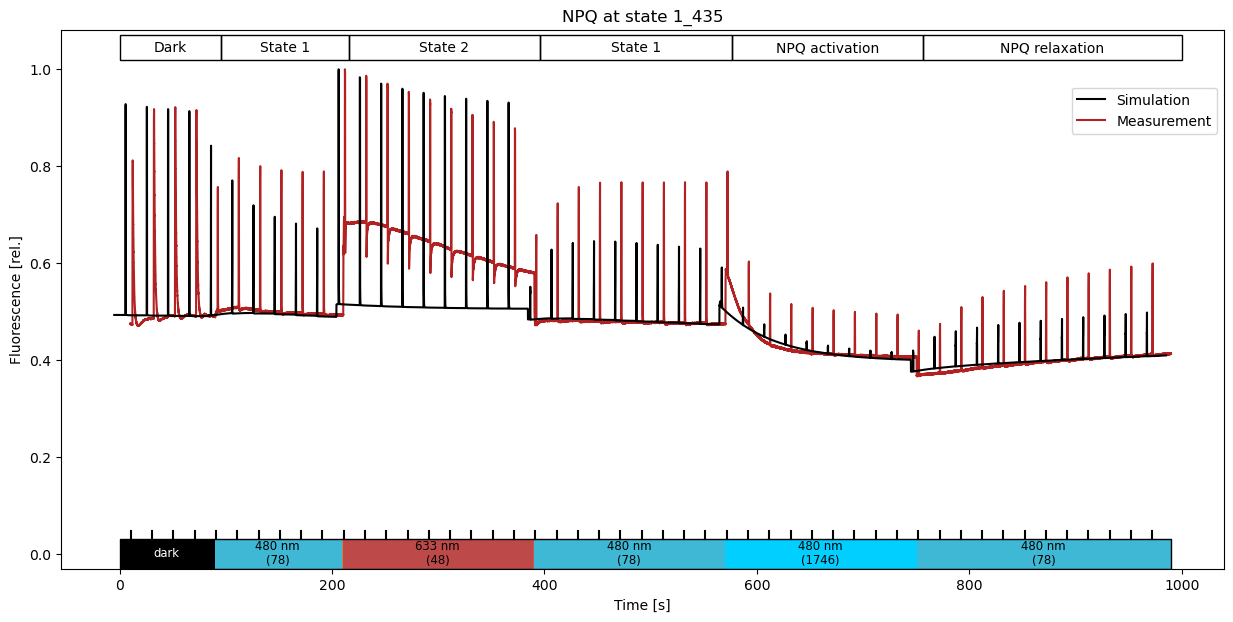

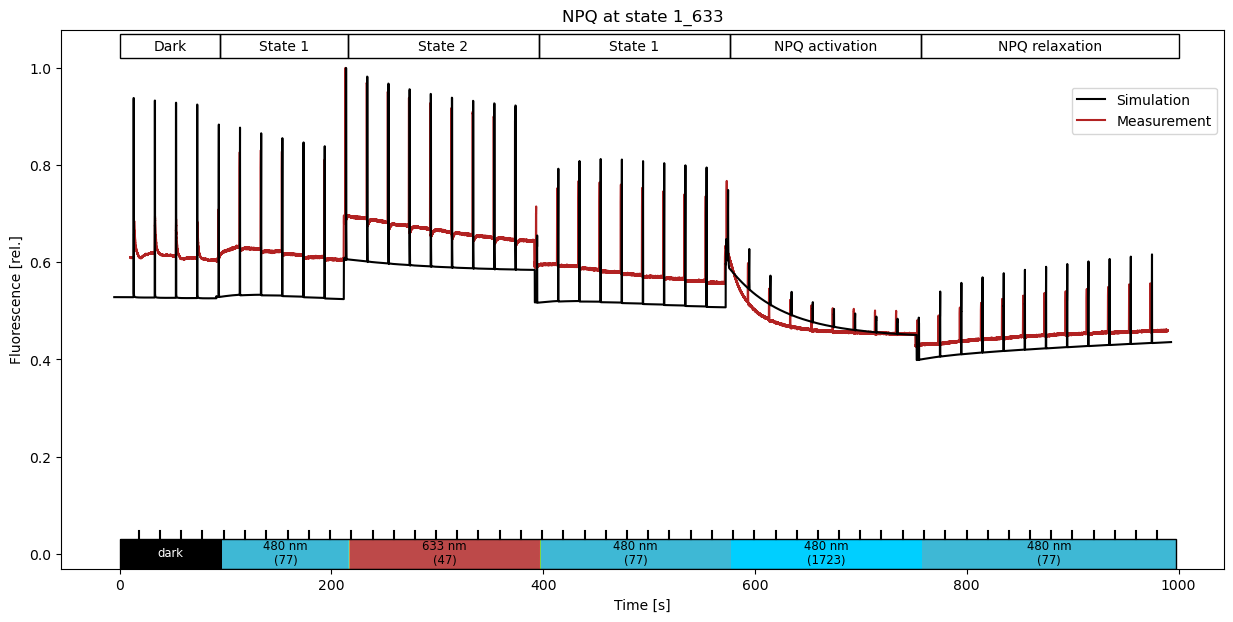

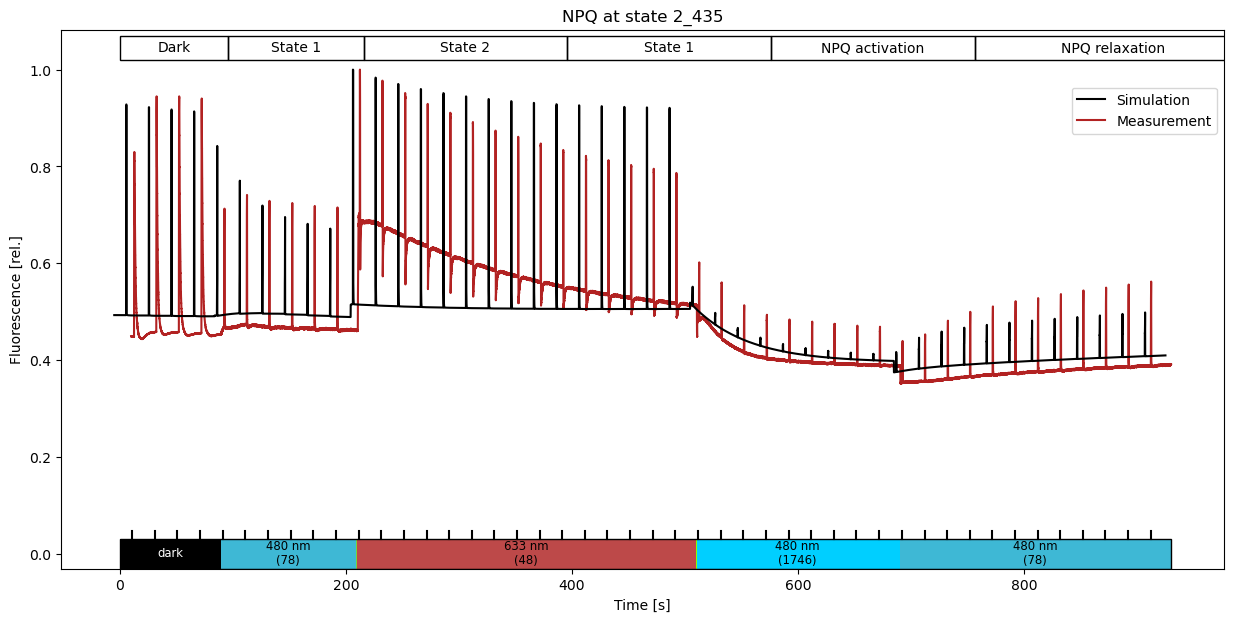

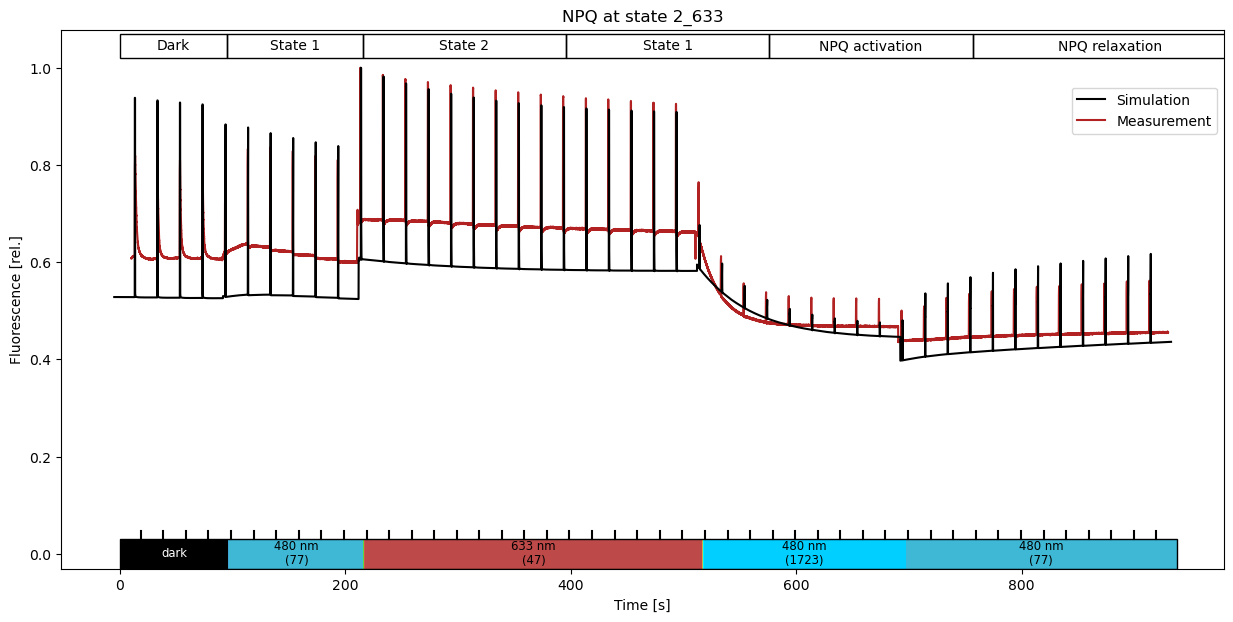

In [ ]:
if settings["PAM_blue_light"]["plot"]:
    for meas_select in meas_types_set:
        if meas_select in sims.keys():
            s4 = sims[meas_select]

            fig, ax = plot_model_and_data(s4, pamdata[meas_select].iloc[:,:2], pulse_pfdm4 * 0.95)

            ax = add_phasebox(ax, 0, 95.3, "Dark", 0.05, 1.02, adj_plotheight=True)
            ax = add_phasebox(ax, 95.3, 215.6, "State 1", 0.05, 1.02)
            ax = add_phasebox(ax, 215.6, 395.9, "State 2", 0.05, 1.02)
            ax = add_phasebox(ax, 395.9, 576.2, "State 1", 0.05, 1.02)
            ax = add_phasebox(ax, 576.2, 756.5, "NPQ activation", 0.05, 1.02)
            ax = add_phasebox(ax, 756.5, 1000, "NPQ relaxation", 0.05, 1.02)

            ax.set_title(meas_select[15:])

            fig.set_size_inches(15,7)
            fnc.savefig_dated(fig, f"rev_dataplot_{meas_select[15:]}", type=plot_format, path=figure_path, bbox_inches="tight")

## Model PAM with saturating pulses

<AxesSubplot: xlabel='Time'>

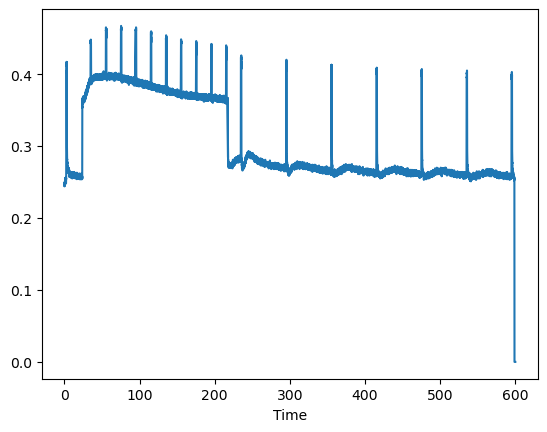

In [ ]:
# Get a blue light meausrment from before
df = pd.read_csv("data/PAM_strong_light_phases/MCPAM_Cyst2_NPQ_Blue.csv", sep=";", index_col=0)["F"]
df.plot()

In [ ]:
intensity_factor = 0.5

dark = lip.light_spectra("solar",)
blue = lip.light_gaussianLED(440, 700 * intensity_factor)
pulse_blue = lip.light_gaussianLED(440, 15000 * intensity_factor)

In [ ]:
protocol = fnc.create_protocol_PAM(
    init=300,
    actinic=(dark, 0),  # Actinic light intensity and duration
    saturating=(
        pulse_blue,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=1,
    first_actinic_time=1,
    final_actinic_time=19,
)

protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(blue, 20),  # Actinic light intensity and duration
    saturating=(
        pulse_blue,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
)

protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(dark, 60),  # Actinic light intensity and duration
    saturating=(
        pulse_blue,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
    first_actinic_time=20,
    final_actinic_time=2,
)

In [ ]:
m,y0 = get_model()
s = Simulator(m)
s.initialise(y0)

s.update_parameters(strain_params["435"]["params"])

s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to hill
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


In [ ]:
fig, ax = s.plot_selection("Fluo")
ax.set_xlim(280)

## Other experiment

In [ ]:
# Get a blue light meausrment from before
df = pd.read_csv("data/PAM_strong_light_phases/Cyst1_Fig3_10s.csv", sep=";", index_col=0).loc[:,["F"]]

In [ ]:
dark = lip.light_spectra("solar", 0.1)
fr = lip.light_gaussianLED(725,700, 10000)
white = lip.light_spectra("cool_white_led", 500)
pulse = lip.light_spectra("cool_white_led", 15000)

In [ ]:
protocol = fnc.create_protocol_const(
    light=dark,
    time=300
)

# FR oxidation
protocol = fnc.create_protocol_const(
    init=protocol,
    light=fr,
    time=5
)

protocol = fnc.create_protocol_const(
    init=protocol,
    light=dark,
    time=1
)

# Initial determination of Fm
protocol = fnc.create_protocol_const(
    init=protocol,
    light=pulse,
    time=0.6
)

protocol = fnc.create_protocol_const(
    init=protocol,
    light=dark,
    time=10
)

# Light phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(white, 60),  # Actinic light intensity and duration
    saturating=(
        pulse,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=11,
    first_actinic_time=59,
    final_actinic_time=1
)

# Dark phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(dark, 60),  # Actinic light intensity and duration
    saturating=(
        pulse,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=7,
    final_actinic_time=10
)

# FR oxidation
protocol = fnc.create_protocol_const(
    init=protocol,
    light=fr,
    time=10
)

protocol = fnc.create_protocol_const(
    init=protocol,
    light=pulse,
    time=0.6
)



In [ ]:
m,y0 = get_model()
s = Simulator(m)
s.initialise(y0)

s.update_parameters({
    "PBS_free": 0.1,  # [unitless] fraction of unbound PBS (guess)
    "PBS_PS1": 0.4,  # [unitless] fraction of PBS bound to PS1 (Tian2011)
    "PBS_PS2": 0.5,  # [unitless] fraction of PBS bound to PS2 (Tian2011)
})

s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)

In [ ]:
fig, ax = _plot_model_and_data(s, df.loc[:1147], 270)
# s_trim = fnc.remove_beginning_from_simulation(s, 290)
# fnc.add_lightbar(s_trim, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)
ax.set_title("10% detached PBS")

# Calculate the steady state redox states (comparison to Khorobrykh2020)

In [64]:
conditions = {
    "air":{"CO2ext_pp":0.0004},
    "CO2enriched":{"CO2ext_pp":0.03}
}

applications = {
    "dark" : {"pfd": lip.light_spectra("solar", 0.1)},
    "growth_light": {"pfd": lip.light_spectra("incandescent_bulb", 40)},
    "far_red": {"pfd": lip.light_gaussianLED(710, 50, 5)},
    "high_light": {"pfd": lip.light_spectra("incandescent_bulb", 2000)},
    "DBMIB": {
        "pfd": lip.light_spectra("incandescent_bulb", 40),
        "k_Q": 0
    },
    "DCMU": {
        "pfd": lip.light_spectra("incandescent_bulb", 40),
        "k2": 0
    }
}

In [ ]:
# Replicate the table of redox states in Khorobrykh2020
Q_reds = pd.DataFrame(index=applications.keys(), columns=pd.MultiIndex.from_product([["light_norm", "chem_norm"],conditions.keys()]))

    # Loop though both CO2 conditions and the applications off different reductants

for condition, cond_par in conditions.items():
    for application, app_par in applications.items():
        # Create the respective model
        m,y0 = get_model()
        s = Simulator(m)
        s.initialise(y0)

        s.update_parameters(cond_par)
        s.update_parameters(app_par)

        # Simulate to steady state
        s, t, y = simulate_to_steady_state_custom(
            s,
            simulation_kwargs={
                "t_end": 1e6,
                "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
                "verbose": True,
            },
            rel_norm=True,
            return_simulator=True,
            **fnc.simulator_kwargs["loose"],
        )
        Q_reds.loc[application, idx[:, condition]] = s.get_full_results_df().loc["Q_red"].iloc[0]

